In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from glob import glob
%matplotlib inline
from matplotlib import pyplot as plt

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/drive/MyDrive/Colab Notebooks/c_d/train/*.jpg')
test_files = glob('/content/drive/MyDrive/Colab Notebooks/c_d/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

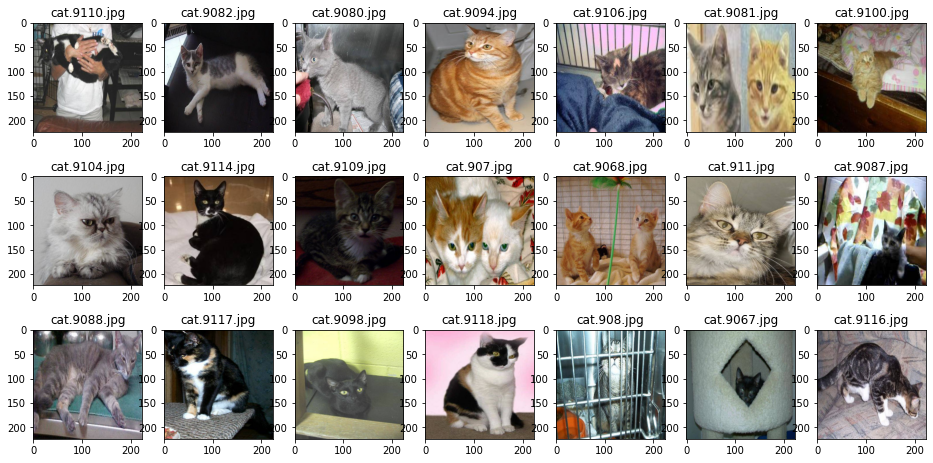

In [9]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:21], 1):
    subplot = fig.add_subplot(3, 7, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [10]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [13]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [14]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [27]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/20
10/10 [==============================] - 55s 6s/step - loss: 40.2707 - accuracy: 0.9187 - val_loss: 0.0608 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 61s 6s/step - loss: 48.0562 - accuracy: 0.8969 - val_loss: 0.0622 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 61s 6s/step - loss: 60.0301 - accuracy: 0.8875 - val_loss: 0.0637 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 61s 6s/step - loss: 67.4479 - accuracy: 0.8719 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 60s 6s/step - loss: 86.2430 - accuracy: 0.8719 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 63s 6s/step - loss: 92.3946 - accuracy: 0.8906 - val_loss: 0.0693 - val_accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 57s 6s/step - loss: 79.8600 - accuracy: 0.8906 - val_loss: 0.0714 - val_accuracy: 1.0000
Epoch 8/20
10

In [28]:
model.save('cats-dogs-vgg16.hdf5')

In [29]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

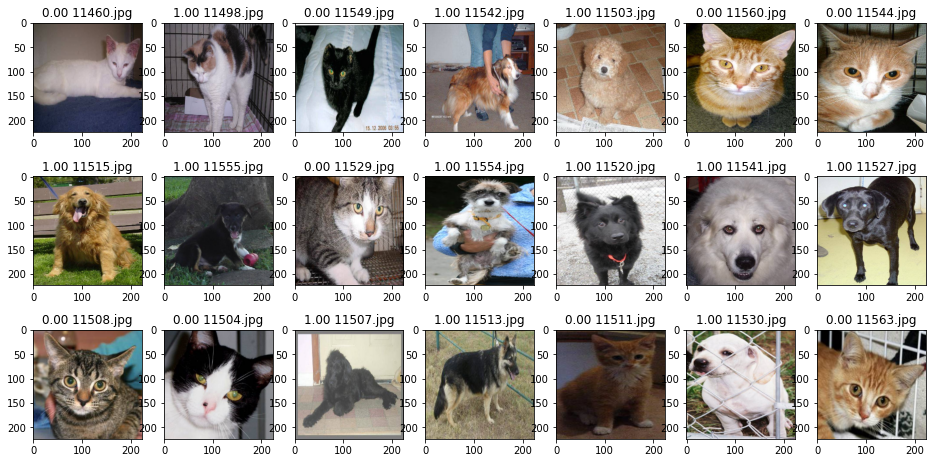

In [30]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:21], test_pred[:21]), 1):
    subplot = fig.add_subplot(3, 7, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)